# Batch Normalization:Accelerating Deep Network Training by Reducing Internal Covariate Shift
# 批处理规范化:通过减少内部协变量移位来加速深度网络训练

# Abstract
# 摘要

Training Deep Neural Networks is complicated by the fact that the distribution of each layer’s inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities. We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs. Our method draws its strength from making normalization a part of the model architecture and performing the  normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization. It also acts as a regularizer, in some cases eliminating the need for Dropout. Applied to a state-of-the-art image classification model, Batch Normalization achieves the same accuracy with 14 times fewer training steps, and beats the original model by a significant margin. Using an ensemble of batchnormalized networks, we improve upon the best published result on ImageNet classification: reaching 4.9% top-5 validation error (and 4.8% test error), exceeding the accuracy of human raters.

批处理归一化:当前一层的参数改变时，每一层的输入分布也会改变，这使得通过减少训练深度神经网络来加速深度网络训练变得复杂。这通过要求较低的学习速率和仔细的参数初始化来降低训练速度，并使得用饱和非线性来训练模型变得非常困难。我们将这种现象称为内部协变量移位，并通过规范化层输入来解决这个问题。我们的方法将规范化作为模型体系结构的一部分，并为每个训练小批执行规范化，从而获得了它的优势。批处理规范化允许我们使用更高的学习速率，并且在初始化时不那么小心。它还作为一个正则化，在某些情况下消除了辍学的需要。应用于最先进的图像分类模型，批处理归一化以少14倍的训练步骤达到了同样的精度，并在很大程度上超过了原始模型。使用一组batchnormalize网络，我们改进了在ImageNet分类上发表的最佳结果:达到4.9%的top 5 validation error(和4.8% test error)，超过了人类评定者的准确率。

# 1 Introduction
# 1 介绍

Deep learning has dramatically advanced the state of the art in vision, speech, and many other areas. Stochastic gradient descent (SGD) has proved to be an effective way of training deep networks, and SGD variants such as momentum (Sutskever et al., 2013) and Adagrad (Duchi et al., 2011) have been used to achieve state of the art performance. SGD optimizes the parameters Θ of the network, so as to minimize the loss

深度学习极大地提高了视觉、语言和许多其他领域的艺术水平。随机梯度下降(SGD)已被证明是一种有效的训练深度网络的方法，SGD变体如momentum (Sutskever et al.， 2013)和Adagrad (Duchi et al.， 2011)已被用来实现最先进的性能状态。SGDΘ网络优化参数,以减少损失

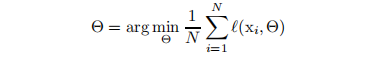

where x1...N is the training data set. With SGD, the training proceeds in steps, and at each step we consider a minibatch x1...m of size m. The mini-batch is used to approximate the gradient of the loss function with respect to the parameters, by computing

x1...N是训练数据集。使用SGD，训练按步骤进行，每一步我们考虑一个minibatch x1...m。通过计算，用小批量近似损失函数相对于参数的梯度

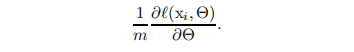


Using mini-batches of examples, as opposed to one example at a time, is helpful in several ways. First, the gradient of the loss over a mini-batch is an estimate of the gradient over the training set, whose quality improves as the batch size increases. Second, computation over a batch can be much more efficient than m computations for individual examples, due to the parallelism afforded by the modern computing platforms.

使用小批量的例子，而不是一次一个例子，在很多方面都是有帮助的。首先，小批处理上的损失梯度是对训练集的梯度的估计，训练集的质量随着批处理大小的增加而提高。其次，由于现代计算平台提供的并行性，批处理的计算可能比单个示例的m计算更有效。

While stochastic gradient is simple and effective, it requires careful tuning of the model hyper-parameters, specifically the learning rate used in optimization, as well as the initial values for the model parameters. The training is complicated by the fact that the inputs to each layer are affected by the parameters of all preceding layers – so that small changes to the network parameters amplify as the network becomes deeper.

虽然随机梯度法简单有效，但它需要对模型超参数进行仔细的调整，特别是用于优化的学习率，以及模型参数的初始值。由于每个层的输入都受到所有前一层的参数的影响，因此，随着网络变得更深，对网络参数的微小变化也会被放大，这使得训练变得更加复杂。

The change in the distributions of layers’ inputs presents a problem because the layers need to continuously adapt to the new distribution. When the input distribution to a learning system changes, it is said to experience covariate shift (Shimodaira, 2000). This is typically handled via domain adaptation (Jiang, 2008). However, the notion of covariate shift can be extended beyond the learning system as a whole, to apply to its parts, such as a sub-network or a layer. Consider a network computing

层的输入分布的变化带来了一个问题，因为层需要不断地适应新的分布。当一个学习系统的输入分布发生变化时，它被称为经历协变量移位(Shimodaira, 2000)。这通常是通过域适应来处理的(Jiang, 2008)。然而，协变量移位的概念可以扩展到整个学习系统之外，应用到它的各个部分，例如子网络或层。考虑一个网络计算

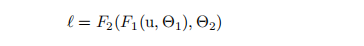

where F1 and F2 are arbitrary transformations, and the parameters Θ1, Θ2 are to be learned so as to minimize the loss ℓ. Learning Θ2 can be viewed as if the inputs x = F1(u, Θ1) are fed into the sub-network

F1和F2任意转换,可以学到和参数Θ1Θ2ℓ以减少损失。学习Θ2可以被视为如果输入x = F1 (u,Θ1)被送入子

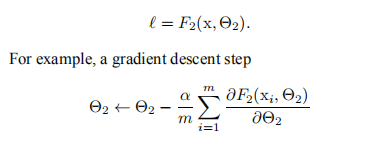

(for batch size m and learning rate α) is exactly equivalent to that for a stand-alone network F2 with input x. Therefore, the input distribution properties that make training more efficient – such as having the same distribution between the training and test data – apply to training the sub-network as well. As such it is advantageous for the distribution of x to remain fixed over time. Then, Θ2 does not have to readjust to compensate for the change in the distribution of x.

(批量大小m和学习速率α)是完全等价的,对于一个独立的网络F2输入x。因此,输入分配属性,使训练更有效,如有相同的分布之间的培训和测试数据,适用于子。因此，随着时间的推移，x的分布保持固定是有利的。然后,Θ2不必调整来弥补x的分布的变化。

Fixed distribution of inputs to a sub-network would have positive consequences for the layers outside the subnetwork, as well. Consider a layer with a sigmoid activation function z = g(Wu + b) where u is the layer input, the weight matrix W and bias vector b are the layer parameters to be learned, and g(x) = 1/1+exp(-x) . As |x| increases, g′(x) tends to zero. This means that for all dimensions of x = Wu+b except those with small absolute values, the gradient flowing down to u will vanish and the model will train slowly. However, since x is affected by W, b and the parameters of all the layers below, changes to those parameters during training will likely move many dimensions of x into the saturated regime of the nonlinearity and slow down the convergence. This effect is amplified as the network depth increases. In practice, the saturation problem and the resulting vanishing gradients are usually addressed by using Rectified Linear Units (Nair & Hinton, 2010) ReLU(x) = max(x, 0), careful initialization (Bengio & Glorot, 2010; Saxe et al., 2013), and small learning rates. If, however, we could ensure that the distribution of nonlinearity inputs remains more stable as the network trains, then the optimizer would be less likely to get stuck in the saturated regime, and the training would accelerate.

对于子网的输入的固定分布也会对子网外部的层产生积极的影响。考虑一个s形激活函数z = g(Wu + b)的层，其中u为层输入，权矩阵W和偏置向量b为待学习的层参数，g(x) = 1/1+exp(-x)。随着|x|的增加，g ' (x)趋于0。这意味着对于x = Wu+b的所有维度，除了那些绝对值较小的维度，流向u的梯度将消失，模型将缓慢训练。但是，由于x受W、b及以下各层参数的影响，在训练过程中，这些参数的变化可能会使x的多个维度进入非线性饱和状态，从而减慢收敛速度。这种效应随着网络深度的增加而增强。在实践中，饱和问题和由此产生的消失梯度通常通过使用修正的线性单元(Nair & Hinton, 2010) ReLU(x) = max(x, 0)，仔细初始化(Bengio & Glorot, 2010;(Saxe et al.， 2013)，和小的学习率。然而，如果我们可以确保非线性输入的分布在网络训练时保持更稳定，那么优化器就不太可能陷入饱和状态，训练就会加速。

We refer to the change in the distributions of internal nodes of a deep network, in the course of training, as Internal Covariate Shift. Eliminating it offers a promise of faster training. We propose a new mechanism, which we call Batch Normalization, that takes a step towards reducing internal covariate shift, and in doing so dramatically accelerates the training of deep neural nets. It accomplishes this via a normalization step that fixes the means and variances of layer inputs. Batch Normalization also has a beneficial effect on the gradient flow through the network, by reducing the dependence of gradients on the scale of the parameters or of their initial values. This allows us to use much higher learning rates without the risk of divergence. Furthermore, batch normalization regularizes the model and reduces the need for Dropout (Srivastava et al., 2014). Finally, Batch Normalization makes it possible to use saturating nonlinearities by preventing the network from getting stuck in the saturated modes.

在训练过程中，我们将深层网络内部节点分布的变化称为内部协变量移位。消除它可以提供更快的训练。我们提出了一种新的机制，我们称之为批处理规范化，它向减少内部协变量移位迈出了一步，并在此过程中极大地加速了深度神经网络的训练。它通过固定层输入的方法和方差的标准化步骤来实现这一点。批处理归一化还对通过网络的梯度流有有益的影响，因为它减少了梯度对参数或其初始值的依赖。这使我们能够使用更高的学习率，而不存在出现分歧的风险。此外，批处理标准化使模型规范化，减少了Dropout的需要(Srivastava et al.， 2014)。最后，批处理规范化通过防止网络陷入饱和模式，使得使用饱和非线性成为可能。

In Sec. 4.2, we apply Batch Normalization to the best performing ImageNet classification network, and show that we can match its performance using only 7% of the training steps, and can further exceed its accuracy by a substantial margin. Using an ensemble of such networks trained with Batch Normalization, we achieve the top-5 error rate that improves upon the best known results on ImageNet classification.

在第4.2节中，我们将批处理归一化应用到性能最好的ImageNet分类网络中，结果表明，我们只需使用7%的训练步骤就可以匹配它的性能，并且可以大大超出它的精度。通过使用批处理归一化训练的网络集合，我们实现了排名前5的错误率，提高了ImageNet分类的最佳结果。








# 2 Towards Reducing Internal Covariate Shift
# 2 减少内部协变量移位

We define Internal Covariate Shift as the change in the distribution of network activations due to the change in network parameters during training. To improve the training, we seek to reduce the internal covariate shift. By fixing the distribution of the layer inputs x as the training progresses, we expect to improve the training speed. It has been long known (LeCun et al., 1998b; Wiesler & Ney, 2011) that the network training converges faster if its inputs are whitened – i.e., linearly transformed to have zero means and unit variances, and decorrelated. As each layer observes the inputs produced by the layers below, it would be advantageous to achieve the same whitening of the inputs of each layer. By whitening the inputs to each layer, we would take a step towards achieving the fixed distributions of inputs that would remove the ill effects of the internal covariate shift.

我们将内部协变位移定义为训练过程中由于网络参数的变化而引起的网络活动分布的变化。为了提高训练质量，我们试图减少内部协变量移位。随着训练的进行，通过固定层输入x的分布，我们期望提高训练速度。这早已为人所知(LeCun et al.， 1998b;Wiesler & Ney(2011)认为，如果网络的输入被加白，那么网络训练的收敛速度会更快。，线性变换为均值和单位方差为零，去相关。由于每一层都观察到下面各层所产生的输入，因此对每一层的输入进行相同的增白将是有利的。通过对每一层的输入进行增白，我们将朝着实现输入的固定分布迈出一步，从而消除内部协变量移位的不良影响。

We could consider whitening activations at every training step or at some interval, either by modifying the network directly or by changing the parameters of the optimization algorithm to depend on the network activation values (Wiesler et al., 2014; Raiko et al., 2012; Povey et al., 2014; Desjardins & Kavukcuoglu). However, if these modifications are interspersed with the optimization steps, then the gradient descent step may attempt to update the parameters in a way that requires the normalization to be updated, which reduces the effect of the gradient step. For example, consider a layer with the input u that adds the learned bias b, and normalizes the result by subtracting the mean of the activation computed over the training data: xb = x E[x] where x = u + b, X = {x1...N } is the set of values of x over the training set, and E[x] = 1/N sigma N i=1 xi. If a gradient descent step ignores the dependence of E[x] on b, then it will update b ← b + ∆b, where ∆b ∝ −∂ℓ/∂x. Then u + (b + ∆b) - E[u + (b + ∆b)] = u + b E[u + b]. Thus, the combination of the update to b and subsequent change in normalization led to no change in the output of the layer nor, consequently, the loss. As the training continues, b will grow indefinitely while the loss remains fixed. This problem can get worse if the normalization not only centers but also scales the activations. We have observed this empirically in initial experiments, where the model blows up when the normalization parameters are computed outside the gradient descent step.

我们可以通过直接修改网络或者根据网络激活值改变优化算法的参数，来考虑在每个训练步骤或在某个区间的美白激活(Wiesler et al.， 2014;雷电子等，2012;Povey et al.， 2014;德斯贾丁斯& Kavukcuoglu)。但是，如果这些修改与优化步骤穿插在一起，那么梯度下降步骤可能会尝试以需要更新规格化的方式更新参数，从而降低梯度步骤的效果。例如，考虑一个带有输入u的层，它添加了学习偏差b，并通过减去训练数据上计算的激活的平均值来将结果正常化:xb = x E[x]，其中x = u + b, x = {x1…N}是x在训练集上的取值集合，E[x] =1 /N∑N i=1 xi。如果忽略了梯度下降法一步依赖b E (x),那么它将更新b←b +∆b, b,∆∝−∂ℓ/∂x。然后u + (b +∆b) - E (u + (b +∆b)) = u + b E (u + b)。因此，对b的更新和随后的标准化更改的组合不会导致层的输出更改，也不会导致损失。随着训练的继续，b将会无限的成长，而损失将会固定。如果标准化不仅集中而且扩展激活，这个问题会变得更糟。在初始实验中，当归一化参数在梯度下降步外计算时，模型会爆炸，我们对此进行了经验观察。

The issue with the above approach is that the gradient descent optimization does not take into account the fact that the normalization takes place. To address this issue, we would like to ensure that, for any parameter values, the network always produces activations with the desired distribution. Doing so would allow the gradient of the loss with respect to the model parameters to account for the normalization, and for its dependence on the model parameters Θ. Let again x be a layer input, treated as a vector, and X be the set of these inputs over the training data set. The normalization can then be written as a transformation

上述方法的问题是，梯度下降优化没有考虑到正常化的事实。为了解决这个问题，我们希望确保对于任何参数值，网络总是生成具有所需分布的激活。这样做会让失去的梯度对模型参数占正常化,Θ和依赖的模型参数。同样，设x是一个层输入，作为一个向量，x是这些输入在训练数据集上的集合，然后可以将标准化写成一个转换

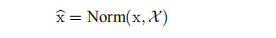

which depends not only on the given training example x but on all examples X – each of which depends on Θ if x is generated by another layer. For backpropagation, we would need to compute the Jacobians

这不仅取决于给定的训练例子但在所有例子x -每个取决于Θ如果x是由另一个层。对于反向传播，我们需要计算雅可比矩阵

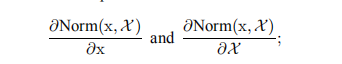

ignoring the latter term would lead to the explosion described above. Within this framework, whitening the layer inputs is expensive, as it requires computing the covariance matrix Cov[x] = Ex∈X [xxT ] E[x]E[x]T and its inverse square root, to produce the whitened activations Cov[x]-1/2(x - E[x]), as well as the derivatives of these transforms for backpropagation. This motivates us to seek an alternative that performs input normalization in a way that is differentiable and does not require the analysis of the entire training set after every parameter update.

忽略后一项将导致上面所述的爆炸。在此框架下，对层输入进行白化是昂贵的，因为需要计算Cov[x] = Ex∈x [xxT]E[x] E[x]T及其逆平方根的协方差矩阵Cov[x] = Ex∈x [x]E[x]T，从而产生白化的激活Cov[x]-1/2(x - E[x])，以及这些变换的导数进行反向传播。这促使我们寻找一种替代方法，以一种可微的方式执行输入规范化，并且不需要在每次更新参数后对整个训练集进行分析。

Some of the previous approaches (e.g. (Lyu & Simoncelli, 2008)) use statistics computed over a single training example, or, in the case of image networks, over different feature maps at a given location. However, this changes the representation ability of a network by discarding the absolute scale of activations. We want to a preserve the information in the network, by normalizing the activations in a training example relative to the statistics of the entire training data.

以前的一些方法(如Lyu和Simoncelli, 2008))使用单个训练示例计算的统计数据，或者，在图像网络的情况下，使用给定位置的不同特征映射计算的统计数据。但是，这将通过丢弃激活的绝对规模来改变网络的表示能力。我们希望通过将训练示例中的激活与整个训练数据的统计数据进行归一化，从而保护网络中的信息。








# 3 Normalization via Mini-Batch Statistics
# 3 .通过小批量统计进行归一化

Since the full whitening of each layer’s inputs is costly and not everywhere differentiable, we make two necessary simplifications. The first is that instead of whitening the features in layer inputs and outputs jointly, we will normalize each scalar feature independently, by making it have the mean of zero and the variance of 1. For a layer with d-dimensional input x = (x(1) . . . x(d)), we will normalize each dimension


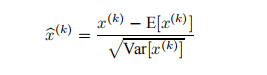

where the expectation and variance are computed over the training data set. As shown in (LeCun et al., 1998b), such normalization speeds up convergence, even when the features are not decorrelated.

如(LeCun et al.， 1998b)所示，即使特征不去相关，这种标准化也能加速收敛。

Note that simply normalizing each input of a layer may change what the layer can represent. For instance, normalizing the inputs of a sigmoid would constrain them to the linear regime of the nonlinearity. To address this, we make sure that the transformation inserted in the network can represent the identity transform. To accomplish this, we introduce, for each activation x(k), a pair of parameters γ(k) , β(k), which scale and shift the normalized value:

注意，简单地规范化一个层的每个输入可能会改变层所能表示的内容。例如，对一个sigmoid的输入进行归一化会将其约束到非线性的线性状态。为了解决这个问题，我们确保插入到网络中的转换可以表示标识转换。为此,我们引入,对于每个激活x (k),一对参数γ(k),β(k),规模和转变归一化值:

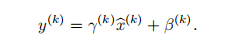

These parameters are learned along with the original model parameters, and restore the representation power of the network. Indeed, by setting γ(k) = The square root of Var[x(k)] and β(k) = E[x(k)], we could recover the original activations, if that were the optimal thing to do.

这些参数与原模型参数一起学习，恢复网络的表示能力。事实上,通过设置γ(k) =根号Var (x (k))和β(k) = E [x (k)],我们可以恢复原来的激活,如果这是最优的事情。

In the batch setting where each training step is based on the entire training set, we would use the whole set to normalize activations. However, this is impractical when using stochastic optimization. Therefore, we make the second simplification: since we use mini-batches in stochastic gradient training, each mini-batch produces estimates of the mean and variance of each activation. This way, the statistics used for normalization can fully participate in the gradient backpropagation. Note that the use of minibatches is enabled by computation of per-dimension variances rather than joint covariances; in the joint case, regularization would be required since the mini-batch size is likely to be smaller than the number of activations being whitened, resulting in singular covariance matrices. 

在批处理设置中，每个训练步骤都基于整个训练集，我们将使用整个训练集来规范化激活。然而，在使用随机优化时，这是不切实际的。因此，我们进行了第二个简化:由于我们在随机梯度训练中使用了小批量，每个小批量生成每个激活的平均值和方差的估计值。这样，用于归一化的统计量可以充分参与梯度反向传播。注意，使用小批量是通过计算每维方差而不是联合协方差来实现的;在联合的情况下，将需要正则化，因为小批处理的大小可能小于正在漂白的激活数，从而导致奇异协方差矩阵。

Consider a mini-batch B of size m. Since the normalization is applied to each activation independently, let us focus on a particular activation x(k) and omit k for clarity. We have m values of this activation in the mini-batch,

考虑一个大小为m的小型批处理B。由于规范化是独立地应用于每个激活的，因此我们将重点放在一个特定的激活x(k)上，为了清楚起见省略k。我们有m个小批量激活的值，

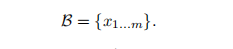

Let the normalized values be x1...m, and their linear transformations be y1...m. We refer to the transform

令规格化后的值为x1…m,它们的线性变换是y1…m。我们指的是变换

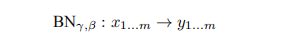

as the Batch Normalizing Transform. We present the BN Transform in Algorithm 1. In the algorithm, ǫ is a constant added to the mini-batch variance for numerical stability.

作为批量正火变换。我们在算法1中给出了BN变换。算法,ǫ是一个常数添加到mini-batch方差的数值稳定性。

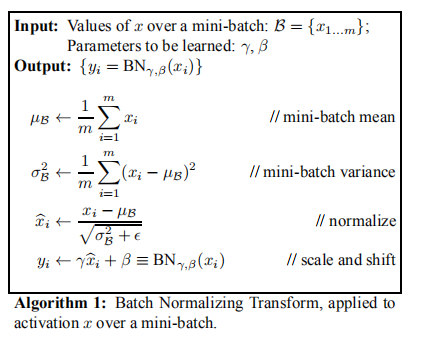

The BN transform can be added to a network to manipulate any activation. In the notation y = BNγ,β(x), we indicate that the parameters γ and β are to be learned, but it should be noted that the BN transform does not independently process the activation in each training example. Rather, BNγ,β(x) depends both on the training example and the other examples in the mini-batch. The scaled and shifted values y are passed to other network layers. The normalized activations xb are internal to our transformation, but their presence is crucial. The distributions of values of any xb has the expected value of 0 and the variance of 1, as long as the elements of each mini-batch are sampled from the same distribution, and if we neglect ǫ. This can be seen by observing that sigma m i=1 xi = 0 and 1/m sigma m i=1 xi^2 = 1, and taking expectations. Each normalized activation xb(k) can be viewed as an input to a sub-network composed of the linear transform y(k) = γ(k)xb(k) + β(k) , followed by the other processing done by the original network. These sub-network inputs all have fixed means and variances, and although the joint distribution of these normalized xb(k) can change over the course of training, we expect that the introduction of normalized inputs accelerates the training of the sub-network and, consequently, the network as a whole.

BN转换可以被添加到网络中来操作任何激活。符号y = BNγ,β(x),我们表明,参数γ和β是需要学习,但应该注意的是,BN变换不独立过程激活在每个培训的例子。BNγ,β(x)都取决于训练例子和mini-batch中的其他例子。缩放和移位的值y被传递到其他网络层。标准化的激活xb是我们转换的内部，但是它们的存在是至关重要的。值的分布的xb的期望值0和1的方差,只要每个mini-batch抽样从相同的元素分布,如果我们忽视ǫ。这可以通过观察m i=1 i= 0和1/m m i=1²=1来观察，并取期望值。每个激活xb正常化(k)可以被视为一个输入子组成的线性变换y (k) =γ(k) xb (k) +β(k),其次是其他处理由原来的网络。这些子网络的输入都有固定的均值和方差，尽管这些标准化的xb(k)的联合分布可能在训练过程中发生变化，但我们期望标准化输入的引入能够加速子网络的训练，从而加速整个网络的训练。

During training we need to backpropagate the gradient of loss ℓ through this transformation, as well as compute the gradients with respect to the parameters of the BN transform. We use chain rule, as follows (before simplification):

培训期间我们需要backpropagateℓ损失通过这个变换的梯度,以及计算梯度对BN的参数变换。我们使用链式法则，如下(化简前):

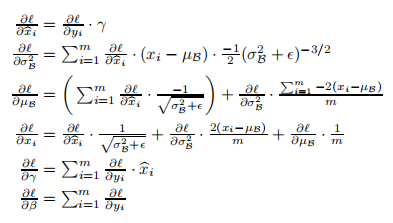

Thus, BN transform is a differentiable transformation that introduces normalized activations into the network. This ensures that as the model is training, layers can continue learning on input distributions that exhibit less internal covariate shift, thus accelerating the training. Furthermore, the learned affine transform applied to these normalized activations allows the BN transform to represent the identity transformation and preserves the network capacity.

因此，BN变换是一个可微变换，它将规范化激活引入到网络中。这确保了在模型进行训练时，层可以继续学习输入分布，这种分布显示较少的内部协变量移位，从而加速了训练。此外，应用于这些标准化激活的学习仿射变换允许BN变换表示身份变换并保留网络容量。

## 3.1 Training and Inference with BatchNormalized Networks
## 3.1批处理规范化网络的训练与推理

To Batch-Normalize a network, we specify a subset of activations and insert the BN transform for each of them, according to Alg. 1. Any layer that previously received x as the input, now receives BN(x). A model employing Batch Normalization can be trained using batch gradient descent, or Stochastic Gradient Descent with a mini-batch size m > 1, or with any of its variants such as Adagrad (Duchi et al., 2011). The normalization of activations that depends on the mini-batch allows efficient training, but is neither necessary nor desirable during inference; we want the output to depend only on the input, deterministically. For this, once the network has been trained, we use the normalization

要对网络进行批处理规范化，我们指定激活的子集，并根据Alg. 1为每个激活插入BN转换。以前接收x作为输入的任何层，现在接收BN(x)。采用批量归一化的模型可以采用批量梯度下降法或小批量m &gt的随机梯度下降法进行训练;或与它的任何变体，如Adagrad (Duchi等人，2011)。依赖于小批处理的激活的规范化允许有效的训练，但在推理期间既没有必要也不可取;我们希望输出只依赖于输入，这是确定的。为此，一旦对网络进行了训练，我们就使用标准化

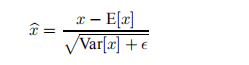


using the population, rather than mini-batch, statistics. Neglecting  , these normalized activations have the same mean 0 and variance 1 as during training. We use the unbiased variance estimate Var[x] = m/m-1 · EB[σ2B], where the expectation is over training mini-batches of size m and σ2B are their sample variances. Using moving averages instead, we can track the accuracy of a model as it trains. Since the means and variances are fixed during inference, the normalization is simply a linear transform applied to each activation. It may further be composed with the scaling by γ and shift by β, to yield a single linear transform that replaces BN(x). Algorithm 2 summarizes the procedure for training batch-normalized networks.

使用总体统计数据，而不是小批量统计数据。忽略后，这些标准化激活的均值0和方差1与训练时相同。我们使用无偏方差估计Var [x] = m / m - 1 EB(σ2B),期望在哪里/培训mini-batches尺寸m和σ2B样本方差。使用移动平均线，我们可以跟踪一个模型的准确性。由于在推理过程中均值和方差是固定的，标准化只是对每个激活应用一个线性变换。可能进一步组成比例由γ和β转变,产生一个线性变换代替BN (x)。算法2总结了批量规范化网络的训练过程。


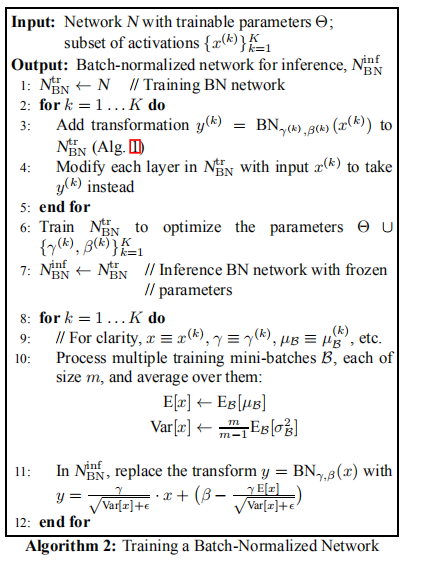





